In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.cuda_cluster import *
from utils.dataset import read_data, factorize_small_cardinality_with_index

import core.config as conf

/home/nyongja/anaconda3/envs/dask/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40571 instead
  http_address["port"], self.http_server.port


In [2]:
client

Client Scheduler: tcp://127.0.0.1:45209 Dashboard: http://127.0.0.1:40571/status,Cluster Workers: 1 Cores: 1 Memory: 33.47 GB


In [3]:
NP = 16
# data_path = conf.raw_data_path + '*' # for all dataset
data_path = conf.raw_data_path + 'part-00000'
ori_df = read_data(data_path)

print('number of rows:',len(ori_df))

number of rows: 3033902


In [4]:
columns = ['engaged_with_user_id', 
           'enaging_user_id',
           'language']
df = ori_df[columns]

In [5]:
df.head()

,engaged_with_user_id,enaging_user_id,language
id,,,
1,BC9980C5385A68894C2862F41884FB27,2AEB7AFFD36CA43C0C963F24F75BCCAC,488B32D24BD4BB44172EB981C1BCA6FA
2,C0EBA033A5C0D2AD91B4500958E2C633,865C52D28FA84E5E233B530C6FDAECC2,B0FA488F2911701DD8EC5B1EA5E322D8
3,03EA05E7440140ABF047BC216CE34917,FE83E568BD4B2ACDBAF876CFBB6C7296,B0FA488F2911701DD8EC5B1EA5E322D8
4,2700B9E175757F126C082D6A5742787D,DB0201BF93E4CCA1B55932AC36923E43,B0FA488F2911701DD8EC5B1EA5E322D8
5,B7E441F2D886830FB3F0CE29CB35CB6B,04F45C4A769FE2D7C792A96C92342DC2,E7F038DE3EAD397AEC9193686C911677


In [6]:
df,language_index, _ = factorize_small_cardinality_with_index(df, "language", "language_encode")

In [7]:
language_index

,index,language
0,0,00304D7356D6C64481190D708D8F739C
1,1,0BB2C843174730BA7D958C98B763A797
2,2,105008E45831ADE8AF1DB888319F422A
3,3,10C6C994C2AD434F9D49D4BE9CFBC613
4,4,159541FA269CA8A9CDB93658CAEC4CA2
...,...,...
61,61,E7F038DE3EAD397AEC9193686C911677
62,62,E84BE2C963852FB065EE827F41A0A304
63,63,F33767F7D7080003F403FDAB34FEB755
64,64,F70598172AC4514B1E6818EA361AD580


In [8]:
df.head()

,engaged_with_user_id,enaging_user_id,language,language_encode
0,AE9BBC744BD724FA5208E6E4E93A38C4,5A8A1B87F9212F51ADE77D0C45B343C6,488B32D24BD4BB44172EB981C1BCA6FA,19
1,FA9984A36340CCD5198DC72C4FB10586,C4AA3BE5B08C120337D7CF431F0911E4,E7F038DE3EAD397AEC9193686C911677,61
2,FE61B3834BE0D4113F1D2298460F75AF,2A28D48F6DAE5BC0DB8889310034A9CF,9A78FC330083E72BE0DD1EA92656F3B5,41
3,08B33AB01E3048DCD74ED55BCE6204C1,8B8ACB07527ED72F492292C37E18E92A,B4DC2F82961F1263E90DF7A942CCE0B2,47
4,667E846ACFAAE626E085DE2468F929F4,EE35FAB0332BF0E216C2A792D78A4DD2,E6936751CBF4F921F7DE1AEF33A16ED0,60


In [9]:
df = df.drop("language", axis = 1)

In [10]:
user_df = df[["engaged_with_user_id"]]

In [11]:
user_a = df["engaged_with_user_id"]
user_b = df["enaging_user_id"]
user_df = dask.dataframe.concat([user_a, user_b], axis = 0).unique().to_frame()

In [12]:
user_df = user_df.rename(columns = {0:"user"})

In [13]:
user_df, user_index, _ = factorize_small_cardinality_with_index(user_df, "user", "user_encode")

In [14]:
user_df.head()

,user,user_encode
0,019860E0D8DACA8E79AE4C7DAA243957,21696
1,0198B5116C98845F7C42F1CAF7FEBC50,21712
2,01989282D00B8D1104448CC6020F2C91,21704
3,0198E9FB8E3D191428C49290831D6297,21720
4,01986403275FBE3B8415FEFFA7BCABD9,21697


In [15]:
df = df.merge(user_index, left_on="engaged_with_user_id", right_on = "user", how='left')

In [16]:
df.head()

,engaged_with_user_id,enaging_user_id,language_encode,index,user
0,E8C422B1BE82922B578CB0DEC288454D,1B6739F20A0945637FDCB65AF540A199,10,3191141,E8C422B1BE82922B578CB0DEC288454D
1,C1479117D84B18ADD13D7D9804CC243B,E5821D6450836FFDD169A1807274983C,61,2649528,C1479117D84B18ADD13D7D9804CC243B
2,F15AF8D6EE911A9EF106E222CD95CC56,ABDAF98FB27B30EF270192D4C3334D36,19,3308736,F15AF8D6EE911A9EF106E222CD95CC56
3,95B3267543E0109479D3667DB6F2A790,A2E70E3C2B9C94FB3BFFFDBC269AA5C8,61,2052645,95B3267543E0109479D3667DB6F2A790
4,912D96318780C715A0AA11B5941E9773,B524BD90C6AB61F4EEF49AB33CA297D5,61,1990884,912D96318780C715A0AA11B5941E9773


In [17]:
df = df.drop("user", axis = 1)
df = df.rename(columns = {"index" : "engaged_user_encode"})

In [18]:
df = df.merge(user_index, left_on="enaging_user_id", right_on = "user", how='left')

In [19]:
df = df.drop("user", axis = 1)
df = df.rename(columns = {"index" : "engaging_user_encode"})

In [20]:
df = df.drop(["engaged_with_user_id", "enaging_user_id"], axis = 1)

In [21]:
df = df.repartition(npartitions=NP)
df, = dask.persist(df)

In [22]:
df.head()

,language_encode,engaged_user_encode,engaging_user_encode
0,19,1959551,653275
1,19,2641946,2195094
2,61,2568710,828015
3,19,1085313,1005522
4,61,437552,1666730


In [23]:
language_df = pd.DataFrame(index=list(range(len(user_index))))
language_df = cudf.DataFrame(language_df)
language_df = dask_cudf.from_cudf(language_df, npartitions=16)
language_df, = dask.persist(language_df)
_ = wait(language_df)
language_df["tmp"] = 0

### engaged language

In [24]:
for i in range(66) :
    engaged_tmp = df[["engaged_user_encode", "language_encode"]][df["language_encode"]==i]
    engaged_tmp = engaged_tmp.groupby("engaged_user_encode").count().head()
    language_df = language_df.merge(engaged_tmp, left_index=True, right_index=True, how='left').astype(np.int32)
    language_df = language_df.rename(columns = {"language_encode":i})

In [25]:
language_df = language_df.drop("tmp", axis = 1)
language_df = language_df.fillna(0)

In [26]:
language_df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
del engaged_tmp

### engaging language

In [28]:
egg_language_df = pd.DataFrame(index=list(range(len(user_index))))
egg_language_df = cudf.DataFrame(egg_language_df)
egg_language_df = dask_cudf.from_cudf(egg_language_df, npartitions=16)
egg_language_df, = dask.persist(egg_language_df)
_ = wait(egg_language_df)
egg_language_df["tmp"] = 0

In [29]:
for i in range(66) :
    engaging_tmp = df[["engaging_user_encode", "language_encode"]][df["language_encode"]==i]
    engaging_tmp = engaging_tmp.groupby("engaging_user_encode").count().head()
    egg_language_df = egg_language_df.merge(engaging_tmp, left_index=True, right_index=True, how='left').astype(np.int32)
    egg_language_df = egg_language_df.rename(columns = {"language_encode":i})

In [30]:
egg_language_df = egg_language_df.drop("tmp", axis =1)
egg_language_df = egg_language_df.fillna(0)

In [31]:
language_df = language_df + egg_language_df

In [32]:
del engaging_tmp 
del egg_language_df

In [33]:
language_df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
languages = language_df.columns

In [35]:
language_df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
count_columns = [f'count_language_{language}_occurence' for language in languages]
language_df.columns = [f'count_language_{language}_occurence' for language in languages]
language_df[count_columns]

,count_language_0_occurence,count_language_1_occurence,count_language_2_occurence,count_language_3_occurence,count_language_4_occurence,count_language_5_occurence,count_language_6_occurence,count_language_7_occurence,count_language_8_occurence,count_language_9_occurence,count_language_10_occurence,count_language_11_occurence,count_language_12_occurence,count_language_13_occurence,count_language_14_occurence,count_language_15_occurence,count_language_16_occurence,count_language_17_occurence,count_language_18_occurence,count_language_19_occurence,count_language_20_occurence,count_language_21_occurence,count_language_22_occurence,count_language_23_occurence,count_language_24_occurence,count_language_25_occurence,count_language_26_occurence,count_language_27_occurence,count_language_28_occurence,count_language_29_occurence,count_language_30_occurence,count_language_31_occurence,count_language_32_occurence,count_language_33_occurence,count_language_34_occurence,count_language_35_occurence,count_language_36_occurence,count_language_37_occurence,count_language_38_occurence,count_language_39_occurence,count_language_40_occurence,count_language_41_occurence,count_language_42_occurence,count_language_43_occurence,count_language_44_occurence,count_language_45_occurence,count_language_46_occurence,count_language_47_occurence,count_language_48_occurence,count_language_49_occurence,count_language_50_occurence,count_language_51_occurence,count_language_52_occurence,count_language_53_occurence,count_language_54_occurence,count_language_55_occurence,count_language_56_occurence,count_language_57_occurence,count_language_58_occurence,count_language_59_occurence,count_language_60_occurence,count_language_61_occurence,count_language_62_occurence,count_language_63_occurence,count_language_64_occurence,count_language_65_occurence
npartitions=278,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32
1241,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505701,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3510048,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [37]:
know_language_columns = [f'know_language_{language}' for language in languages]
for language in languages:   
    language_df[f'know_language_{language}'] = language_df[f'count_language_{language}_occurence'] > 0
language_df[know_language_columns]

,know_language_0,know_language_1,know_language_2,know_language_3,know_language_4,know_language_5,know_language_6,know_language_7,know_language_8,know_language_9,know_language_10,know_language_11,know_language_12,know_language_13,know_language_14,know_language_15,know_language_16,know_language_17,know_language_18,know_language_19,know_language_20,know_language_21,know_language_22,know_language_23,know_language_24,know_language_25,know_language_26,know_language_27,know_language_28,know_language_29,know_language_30,know_language_31,know_language_32,know_language_33,know_language_34,know_language_35,know_language_36,know_language_37,know_language_38,know_language_39,know_language_40,know_language_41,know_language_42,know_language_43,know_language_44,know_language_45,know_language_46,know_language_47,know_language_48,know_language_49,know_language_50,know_language_51,know_language_52,know_language_53,know_language_54,know_language_55,know_language_56,know_language_57,know_language_58,know_language_59,know_language_60,know_language_61,know_language_62,know_language_63,know_language_64,know_language_65
npartitions=278,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
1241,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505701,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3510048,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [38]:
language_df.head()

,count_language_0_occurence,count_language_1_occurence,count_language_2_occurence,count_language_3_occurence,count_language_4_occurence,count_language_5_occurence,count_language_6_occurence,count_language_7_occurence,count_language_8_occurence,count_language_9_occurence,...,know_language_56,know_language_57,know_language_58,know_language_59,know_language_60,know_language_61,know_language_62,know_language_63,know_language_64,know_language_65
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [39]:
language_df['total_count_language_occurence'] = language_df[count_columns].sum(axis=1)
language_df['total_count_language_occurence'].head()

0    0
1    0
2    0
3    0
4    0
Name: total_count_language_occurence, dtype: int64

In [40]:
language_df['total_known_language'] = language_df[know_language_columns].sum(axis=1)

# How many languages does users know?

TypeError: float() argument must be a string or a number, not 'method'

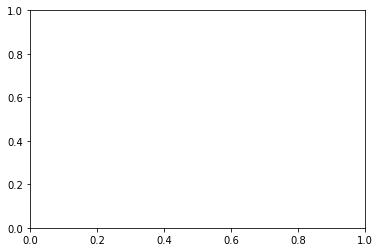

In [49]:
#plt.plot(list(language_df['total_known_language'].map_partitions(lambda x : x.sort_values())))
plt.plot(language_df['total_known_language'].compute().sort_values)
plt.xlabel("users")
plt.ylabel("known languages")

plt.show()

In [ ]:
list(language_df['total_known_language'].map_partitions(lambda x : x.sort_values()))

In [ ]:
%%time
sum_df = language_df.sum().compute()

In [ ]:
sum_df_know_language = sum_df[know_language_columns]
sum_df_count_occurence = sum_df[count_columns]

### How many users know a certain language?


In [ ]:
type(sum_df_know_language)

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
idx = languages
values = sum_df_know_language.values.tolist()
plt.bar(idx, values)

plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.yscale('log')
idx = languages
values = sum_df_know_language.values.tolist()
plt.bar(idx, values)

plt.show()

### How many times the language has been interacted with?

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
idx = languages
values = sum_df_count_occurence.values.tolist()
plt.bar(idx, values)

plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.yscale('log')
idx = languages
values = sum_df_count_occurence.values.tolist()
plt.bar(idx, values)

plt.show()

## Let's consider the people that know only one language

How many are them?
How many interactions have they made in that language?


In [ ]:
sum_df_user_that_know_1_language = language_df[language_df['total_known_language'] == 1].sum().compute()
sum_df_user_that_know_1_know_language = sum_df_user_that_know_1_language[know_language_columns]
sum_df_user_that_know_1_count_occurence = sum_df_user_that_know_1_language[count_columns]

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
print(sum_df_user_that_know_1_know_language)
idx = languages
values = sum_df_user_that_know_1_know_language.values.tolist()
plt.bar(idx, values)

plt.show()


plt.rcParams['figure.figsize'] = [15, 5]
print(sum_df_user_that_know_1_count_occurence)
idx = languages
values = sum_df_user_that_know_1_count_occurence.values.tolist()
plt.bar(idx, values)

plt.show()


### Plot the percentage of users that knows only one language with respect to the overall amount of users that know that language

In [ ]:
idx = languages
values = (sum_df_user_that_know_1_count_occurence/sum_df_count_occurence).values.tolist()
plt.bar(idx, values)
plt.show()


## Let's consider only the multilingual users

So just only those ones that have interacted with 2 or more languages


In [ ]:
%%time
sum_df_user_that_know_2_or_more_languages = language_df[language_df['total_known_language'] >= 2].sum().compute()

In [ ]:
sum_df_user_that_know_2_or_more_languages_know_language = sum_df_user_that_know_2_or_more_languages[know_language_columns]
sum_df_user_that_know_2_or_more_languages_count_occurence = sum_df_user_that_know_2_or_more_languages[count_columns]

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
idx = languages
values = sum_df_user_that_know_2_or_more_languages_know_language.values.tolist()
plt.bar(idx, values)

plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.yscale('log')

idx = languages
values = sum_df_user_that_know_2_or_more_languages_know_language.values.tolist()
plt.bar(idx, values)


### Among the multilingual, how many a language has been used?

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
idx = languages
values = sum_df_user_that_know_2_or_more_languages_count_occurence.values.tolist()
plt.bar(idx, values)

plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.yscale('log')
idx = languages
values = sum_df_user_that_know_2_or_more_languages_count_occurence.values.tolist()
plt.bar(idx, values)

plt.show()